# Himanshu MDS202327

In [ ]:
# Importing relevant libraries
import json
import re
import string
import os
import glob
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download("stopwords", quiet=True)
nltk.download('punkt', quiet=True)

from multiprocessing import Pool, cpu_count, Lock
from functools import partial
from tqdm import tqdm
from collections import Counter
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from IPython.display import display, Math

### Task 1
Extract the text content from the JSON-encoded data set and create a
text corpus. You may use any JSON library to extract the text.

In [ ]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
corpus_path_drive = '/content/drive/MyDrive/NLP/corpus_cleaned.txt'

In [ ]:
# Unzip the file
!unzip /content/drive/MyDrive/NLP/pdf_json.zip

In [ ]:
# Extracting text from json file considering only title, abstract, body_text
def json2text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        content = json.load(file)
    title = content.get('metadata', {}).get('title', '')
    abstract = ' '.join([abs['text'] for abs in content.get('abstract', [])])
    body_text = ' '.join([bt['text'] for bt in content.get('body_text', [])])
    return f"{title} {abstract} {body_text}".lower()

# Build corpus of text using multiprocessing
def build_corpus(files, num_workers=4):
    with multiprocessing.Pool(num_workers) as pool:
        corpus = list(tqdm(pool.imap(json2text, files), total=len(files)))
    return corpus

In [ ]:
directory = '/content/pdf_json'
file_list = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.json')]
file_list = file_list[:10000]
corpus = build_corpus(file_list)

100%|██████████| 10000/10000 [00:17<00:00, 565.44it/s]


In [ ]:
with open('/content/corpus.txt', 'w', encoding='utf-8') as corpus_file:
    for text in corpus:
        corpus_file.write(text + '\n')

### Task 2

Develop your pre-processing steps (case-folding, removal of numbers, etc.)
and order of steps

In [ ]:
# Remove punctuatios
def rm_punct(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]
    return ' '.join(tokens)

# Remove URLs and numbers
def rm_urls_num(text):
    pattern = re.compile(r'https?://\S+|www\.\S+|\d+')
    return pattern.sub('', text)

# Clean and process each line
def process_line(line):
    line = line.lower()
    line = rm_urls_num(line)
    line = rm_punct(line)
    if line.strip():
        return line
    return None

def process_corpus(lines):

    with Pool(cpu_count()) as pool:
        processed_lines = list(tqdm(pool.imap(process_line, lines), total=len(lines), desc='Processing Lines'))

    return processed_lines

In [ ]:
with open('/content/corpus.txt', 'r') as file:
    lines = file.readlines()

In [ ]:
if __name__ == "__main__":
    with Pool(cpu_count()) as pool:
        processed_corpus = list(tqdm(pool.imap(process_line, lines), total=len(lines), desc='Processing Lines'))

    with open('/content/corpus_cleaned.txt', 'w') as file:
        for line in processed_corpus:
            if line:
                file.write(line + '\n')

Processing Lines: 100%|██████████| 10000/10000 [06:46<00:00, 24.58it/s]


In [ ]:
with open('/content/corpus_cleaned.txt', 'w') as file:
    for line in processed_corpus:
        if line:
            file.write(line + '\n')

### Task 3

Find the weighted term frequency for every word in the corpus and order
it according to its rank using Zipf’s Law. Find the value of the α using
the data obtained from the previous step

In [ ]:
def read_corpus(file_path):
    with open(file_path, 'r') as file:
        return file.read()

def tokenize(text):
    return re.findall(r'\b\w+\b', text)

def compute_tf(chunk):
    tokens = tokenize(chunk)
    return Counter(tokens)

def split_corpus(corpus, num_chunks):
    chunk_size = len(corpus) // num_chunks
    return [corpus[i:i + chunk_size] for i in range(0, len(corpus), chunk_size)]

def main():
    corpus = read_corpus(corpus_path_drive)
    num_processes = cpu_count()
    split_corpus(corpus, num_processes)
    chunks = split_corpus(corpus, num_processes)

    with Pool(num_processes) as pool:
        results = list(tqdm(pool.imap(compute_tf, chunks), total=num_processes, desc='Processing chunks'))

    total_counter = Counter()
    for result in results:
        total_counter.update(result)

    z_df = pd.DataFrame(total_counter.items(), columns=['Word', 'Frequency'])
    print("DataFrame preview:")
    print(z_df.head())

    return z_df

In [ ]:
z_df = main()

Processing chunks: 97it [00:01, 63.41it/s]                        


DataFrame preview:
         Word  Frequency
0  evaluation       6987
1          of    1439364
2         the    2125757
3       human      39960
4  adaptation       1591


In [ ]:
z_df

In [ ]:
sorted_df = z_df.sort_values(by='Frequency', ascending=False)

sorted_df = sorted_df.reset_index(drop=True)
sorted_df.index = sorted_df.index + 1

In [ ]:
# Maximum frequency
max_frequency = sorted_df['Frequency'].max()

# Weighted term frequency
sorted_df['weighted_term_frequency'] = sorted_df['Frequency'] / max_frequency

# Calculate log10 of index and frequency columns
sorted_df['log10_index'] = np.log10(sorted_df.index)
sorted_df['log10_frequency'] = np.log10(sorted_df['Frequency'])

In [ ]:
sorted_df.head()

,Word,Frequency,weighted_term_frequency,log10_index,log10_frequency
1,the,2125757,1.000000,0.000000,6.327514
2,of,1439364,0.677107,0.301030,6.158171
3,and,1222941,0.575297,0.477121,6.087406
4,in,963206,0.453112,0.602060,5.983719
5,to,830501,0.390685,0.698970,5.919340


In [ ]:
# Prepare data for linear regression
X = sorted_df[['log10_index']].values  # Predictor (independent variable)
y = sorted_df['log10_frequency'].values  # Response (dependent variable)

# Create and fit the model
model = LinearRegression()
model.fit(X, y)
display(Math(f'\\text{{Expected }} \\alpha \\text{{ is: }} {-model.coef_[0]}'))

<IPython.core.display.Math object>

###  Task 4

Print the number of tokens and the vocabulary

In [ ]:
def process_chunk(chunk):
    tokens = chunk.split()  # Tokenize by splitting on whitespace
    return tokens

def read_in_chunks(file_path, chunk_size=1024*1024):  # 1MB chunks
    with open(file_path, 'r', encoding='utf-8') as f:
        while True:
            data = f.read(chunk_size)
            if not data:
                break
            yield data

def count_tokens_and_vocabulary(file_path):
    total_tokens = 0
    token_counter = Counter()

    with Pool(processes=cpu_count()) as pool:
        chunks = read_in_chunks(file_path)
        for tokens in tqdm(pool.imap_unordered(process_chunk, chunks), desc="Processing Chunks"):
            total_tokens += len(tokens)
            token_counter.update(tokens)

    return total_tokens, token_counter

In [ ]:
total_tokens, token_counter = count_tokens_and_vocabulary(corpus_path_drive)

print(f"Number of tokens: {total_tokens}")
print(f"Vocabulary size: {len(token_counter)}")

Processing Chunks: 234it [00:11, 19.78it/s]


Number of tokens: 37878205
Vocabulary size: 519651


### Task 5

Plot Tokens Vs Vocabulary graph using Heaps’ empirical law. Find Vocabulary count for every 10000 tokens. You may use a log scale for plotting

In [ ]:
# While iterating with the number of tokens, we keep track vocabulary into a pair (x,y)
def process_file(file_path):
    token_vocabulary_pairs = []

    vocabulary = set()

    token_count = 0

    with open(file_path, 'r', encoding='utf-8') as file:
        total_lines = sum(1 for _ in file)

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in tqdm(file, total=total_lines, desc="Processing tokens"):
            tokens = line.split()

            for token in tokens:
                token_count += 1
                vocabulary.add(token)
                token_vocabulary_pairs.append((token_count, len(vocabulary)))

    return token_vocabulary_pairs

In [ ]:
pairs = process_file(corpus_path_drive)

Processing tokens: 100%|██████████| 10000/10000 [00:18<00:00, 545.38it/s]


In [ ]:
def plot_log_pairs(pairs):
    # Convert pairs to numpy arrays for easier manipulation
    print("Converting pairs to numpy arrays...")
    token_counts, vocab_sizes = zip(*pairs)

    # Convert to numpy arrays and calculate logarithms
    print("Calculating logarithms...")
    log_token_counts = np.log10(token_counts)
    log_vocab_sizes = np.log10(vocab_sizes)

    # Add a column of ones for the intercept term
    print("Setting up matrices for linear regression...")
    A = np.vstack([log_token_counts, np.ones(len(log_token_counts))]).T
    b = log_vocab_sizes

    # Perform linear regression and track progress
    print("Performing linear regression...")
    # Use tqdm to show progress
    for _ in tqdm(range(1)):  # tqdm progress bar for linear regression
        slope, intercept = np.linalg.lstsq(A, b, rcond=None)[0]

    # Generate fitted line values
    print("Generating fitted line values...")
    log_token_counts_range = np.linspace(min(log_token_counts), max(log_token_counts), 100)
    fitted_line = slope * log_token_counts_range + intercept

    # Plotting
    print("Plotting the results...")
    plt.figure(figsize=(10, 6))
    plt.scatter(log_token_counts, log_vocab_sizes, s=1, alpha=0.5, label='Data points')
    plt.plot(log_token_counts_range, fitted_line, color='red', label='Fitted line')
    plt.xlabel('Log of Token Count')
    plt.ylabel('Log of Vocabulary Size')
    plt.title('Log-Log Plot of Token Count vs. Vocabulary Size')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Return the values from the fitted line
    return log_token_counts_range, fitted_line

Converting pairs to numpy arrays...
Calculating logarithms...
Setting up matrices for linear regression...
Performing linear regression...


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Generating fitted line values...
Plotting the results...


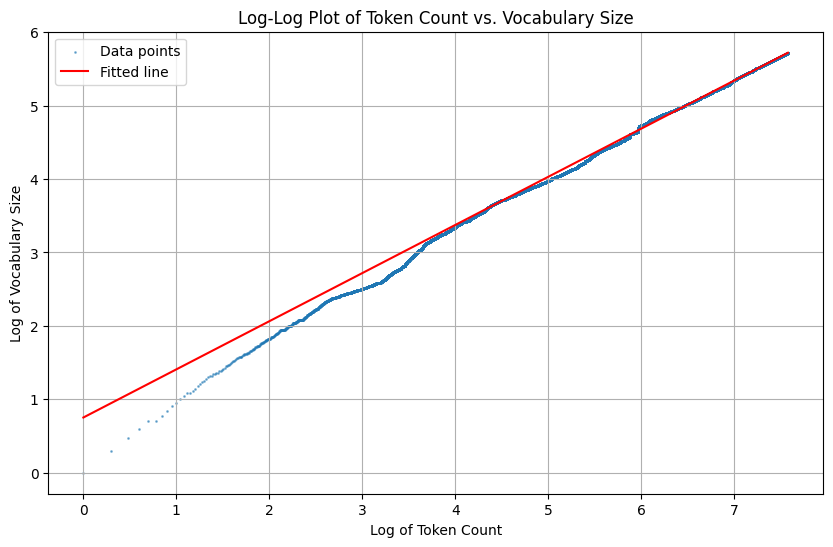

In [ ]:
count, line = plot_log_pairs(pairs)

In [ ]:
# Chunk size
chunk_size = 10000

start = 0
end = chunk_size
vocab_size_list = []

# Open the file
with open(corpus_path_drive, 'r') as file:
    text = file.read()

    tokens = text.split()

    while start < len(tokens):
        chunk_tokens = tokens[start:end]

        # Calculate vocabulary size for the current chunk
        vocab_size = len(set(chunk_tokens))
        vocab_size_list.append((f'{start + 1}-{end}', vocab_size))

        start = end
        end = start + chunk_size

vocab_df = pd.DataFrame(vocab_size_list, columns=['Token Range', 'Vocabulary Size'])

In [ ]:
vocab_df.head(50)

,Token Range,Vocabulary Size
0,1-10000,2224
1,10001-20000,2119
2,20001-30000,2343
3,30001-40000,2038
4,40001-50000,2055
5,50001-60000,1990
6,60001-70000,1960
7,70001-80000,2052
8,80001-90000,2098
9,90001-100000,2089


In [ ]:
save_path = '/content/drive/MyDrive/NLP/word_frequencies.csv'
z_df.to_csv(save_path, index=False)